ARIMA

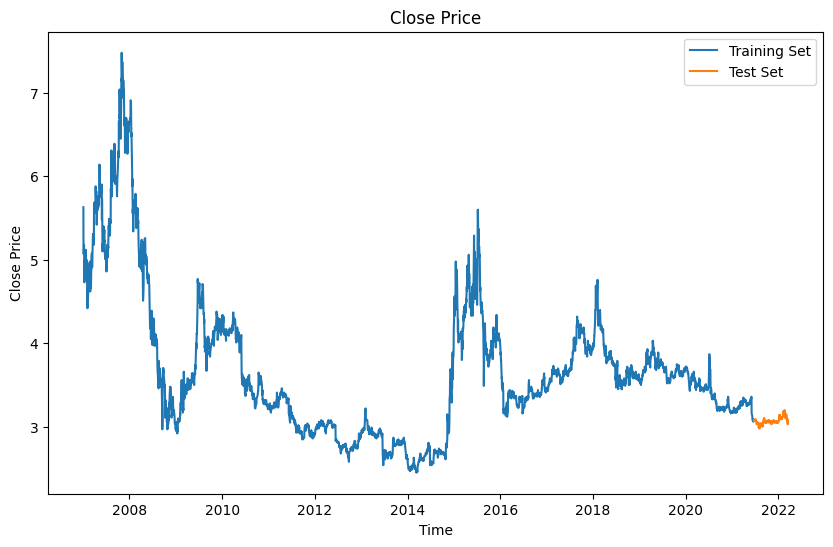

<ipython-input-1-e52b20481f0b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_1'] = training_set['close'].diff()
<ipython-input-1-e52b20481f0b>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['diff_2'] = training_set['diff_1'].diff()


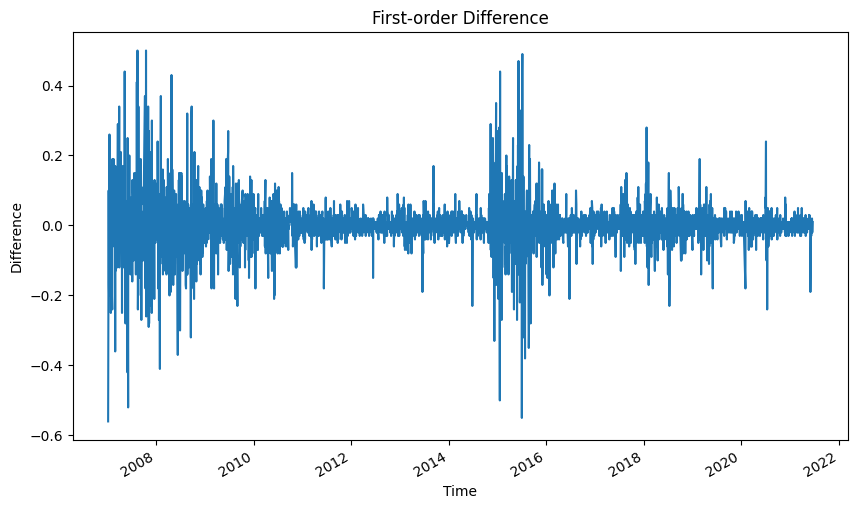

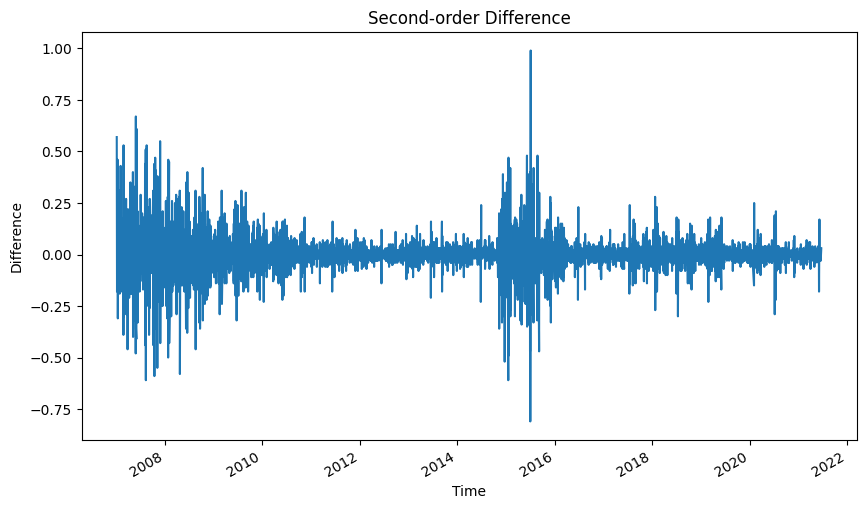

Ljung-Box test:      lb_stat  lb_pvalue    bp_stat  bp_pvalue
1   3.458346   0.062933   3.455383   0.063046
2  23.695323   0.000007  23.669246   0.000007


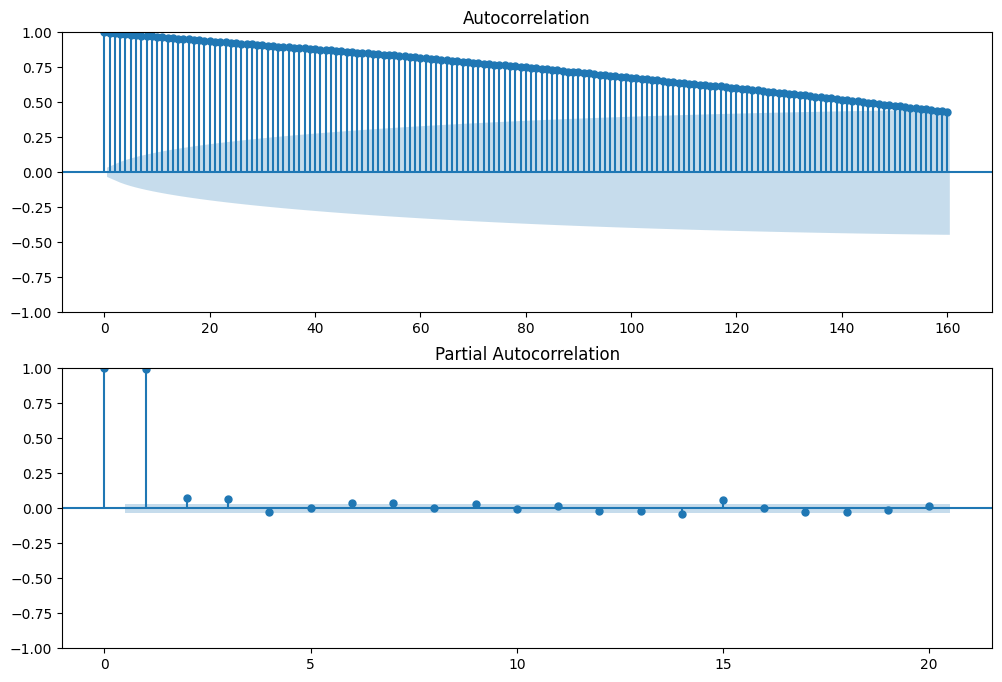

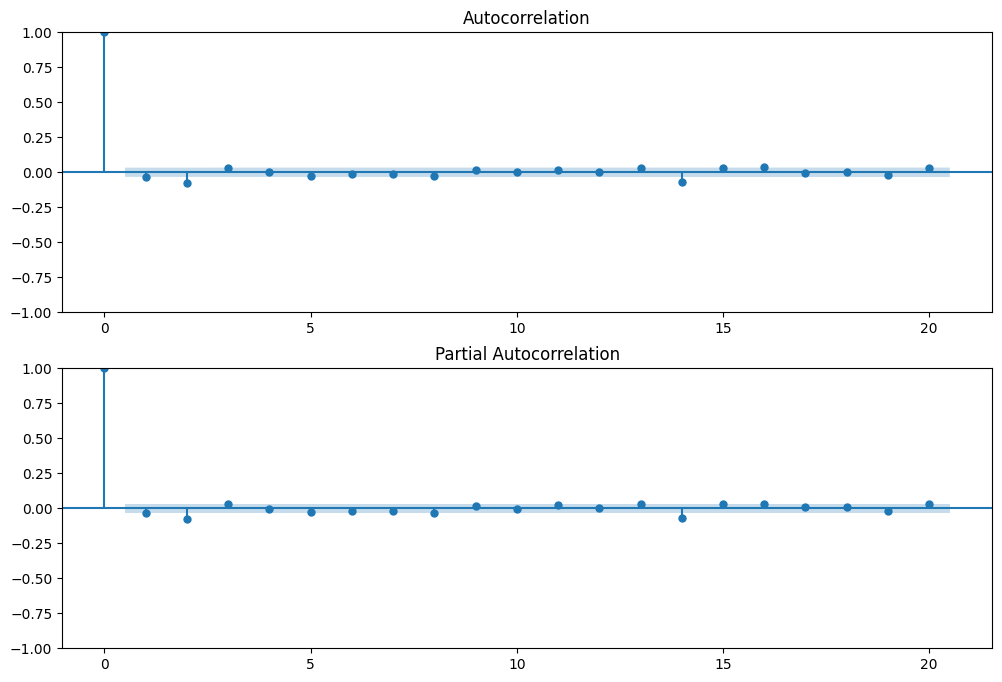

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


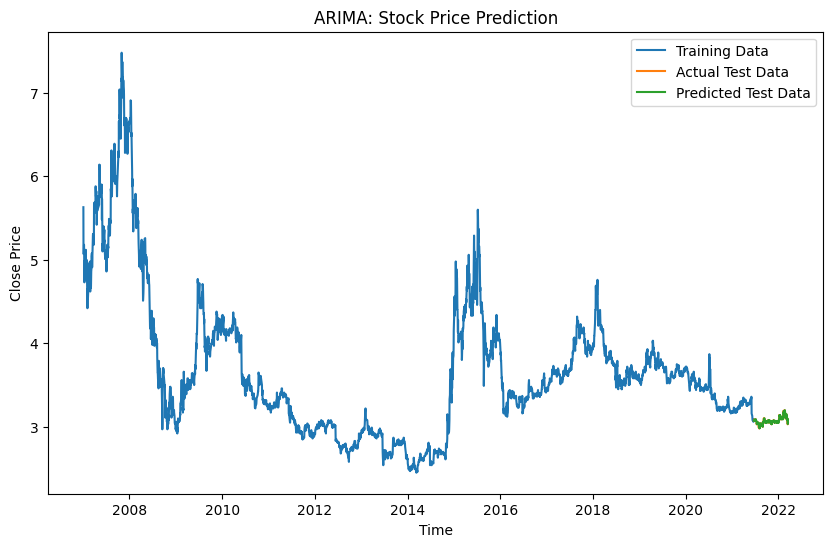

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


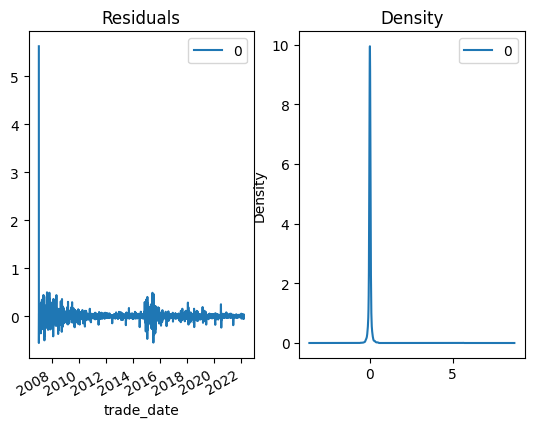


Training Metrics:
MSE: 0.01421
RMSE: 0.11919
MAE: 0.04260
R2: 0.98040
Accuracy: 98.84%

Testing Metrics:
MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439
Accuracy: 99.61%


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from utils import acf_pacf_plot, evaluation_metric, adf_test

# Load data
data = pd.read_csv('./601988.SH.csv')
test_set2 = data.loc[3501:, :]
data.index = pd.to_datetime(data['trade_date'], format='%Y%m%d')
data = data.drop(['ts_code', 'trade_date'], axis=1)
data = pd.DataFrame(data, dtype=np.float64)

# Split data into training and test sets
training_set = data.loc['2007-01-04':'2021-06-21', :]
test_set = data.loc['2021-06-22':, :]

# Plot the close price
plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='Training Set')
plt.plot(test_set['close'], label='Test Set')
plt.title('Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Calculate first-order and second-order differences
training_set['diff_1'] = training_set['close'].diff()
training_set['diff_2'] = training_set['diff_1'].diff()

# Plot first-order difference
plt.figure(figsize=(10, 6))
training_set['diff_1'].plot()
plt.title('First-order Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

# Plot second-order difference
plt.figure(figsize=(10, 6))
training_set['diff_2'].plot()
plt.title('Second-order Difference')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.show()

# White noise test
temp2 = np.diff(training_set['close'].dropna(), n=1)
print("Ljung-Box test:", acorr_ljungbox(temp2, lags=2, boxpierce=True))

# Plot ACF and PACF
acf_pacf_plot(training_set['close'].dropna(), acf_lags=160)

# Prepare data for ARIMA modeling
data2 = {
    'trade_date': training_set['diff_1'].index[1:],
    'close': list(temp2)
}
df = pd.DataFrame(data2).set_index('trade_date')

# Plot ACF and PACF of first-order differenced data
acf_pacf_plot(df['close'])

# Fit ARIMA model
model = ARIMA(endog=training_set['close'], order=(2, 1, 0)).fit()
train_pred = model.fittedvalues

# Forecast using ARIMA model
history = training_set['close'].tolist()
predictions = []
for t in range(len(test_set)):
    model1 = ARIMA(history, order=(2, 1, 0))
    model_fit = model1.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    obs = test_set2.iloc[t, 5]
    history.append(obs)

# Save and plot predictions
predictions1 = pd.DataFrame({
    'trade_date': test_set.index,
    'close': predictions
}).set_index('trade_date')
predictions1.to_csv('./ARIMA.csv')

# Convert test predictions to a DataFrame
test_predictions = pd.Series(predictions, index=test_set.index)

# Plot actual vs. predicted stock prices
plt.figure(figsize=(10, 6))
plt.plot(training_set['close'], label='Training Data')
plt.plot(test_set['close'], label='Actual Test Data')
plt.plot(test_predictions, label='Predicted Test Data')
plt.title('ARIMA: Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

model2 = ARIMA(endog=data['close'], order=(2, 1, 0)).fit()
residuals = pd.DataFrame(model2.resid)
fig, ax = plt.subplots(1, 2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
residuals.to_csv('./ARIMA_residuals1.csv')

# Evaluate model using the provided evaluation_metric function
evaluation_metric(
    y_train=training_set['close'],
    y_train_pred=train_pred,
    y_test=test_set['close'],
    y_test_pred=test_predictions
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 7)          │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 20, 64)         │            512 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 20, 64)         │              0 │ conv1d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 20, 128)        │         66,048 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 20, 128)        │              0 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 20, 128)        │         16,512 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 20, 128)        │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 20, 128)        │              0 │ dropout_1[0][0],       │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2560)           │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │          2,561 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 85,633 (334.50 KB)

 Trainable params: 85,633 (334.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.0149 - val_loss: 1.7088e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0014 - val_loss: 1.7112e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0012 - val_loss: 3.7623e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0011 - val_loss: 1.4940e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 6.7755e-04 - val_loss: 1.0559e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.4480e-04 - val_loss: 5.6175e-04
Epoch 7/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 8.2761e-04 - val_loss: 3.9590e-04
Epoch 8/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.0881e-04 - val_loss: 9.5457e-05
Epoch 9/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 7.1173e-04 - val_loss: 2.1233e-04
Epoch 10/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 4.9242e-04 - val_loss: 1.7679e-04
Epoch 11/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 9.4447e-04 - val_loss: 1

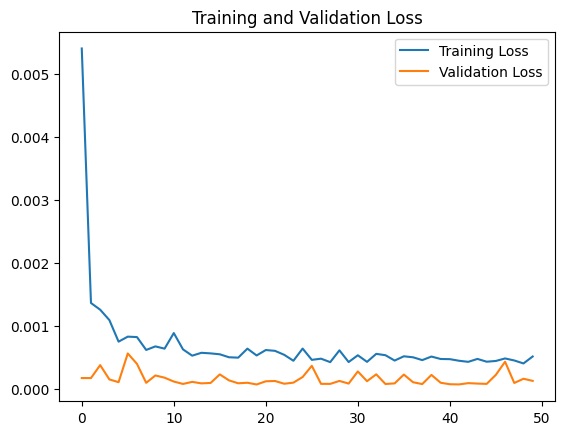

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, Permute, Flatten, Lambda, RepeatVector, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import xgboost as xgb

def NormalizeMult(data):
    data = np.array(data, dtype='float64')
    num_features = data.shape[1]
    normalize = np.zeros((num_features, 2))
    normalized_data = np.zeros_like(data)

    for i in range(num_features):
        column_data = data[:, i]
        column_min, column_max = np.percentile(column_data, [0, 100])
        normalize[i] = [column_min, column_max]
        delta = column_max - column_min

        if delta != 0:
            normalized_data[:, i] = (column_data - column_min) / delta
        else:
            normalized_data[:, i] = 0.5
    return normalized_data, normalize

def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Define evaluation metric function
def evaluation_metric(y_train, y_train_pred, y_test, y_test_pred):

    train_MSE = metrics.mean_squared_error(y_train, y_train_pred)
    train_RMSE = train_MSE**0.5
    train_MAE = metrics.mean_absolute_error(y_train, y_train_pred)
    train_R2 = metrics.r2_score(y_train, y_train_pred)
    train_avg_actual_value = np.mean(y_train)
    train_accuracy = (1 - train_MAE / train_avg_actual_value) * 100

    test_MSE = metrics.mean_squared_error(y_test, y_test_pred)
    test_RMSE = test_MSE**0.5
    test_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
    test_R2 = metrics.r2_score(y_test, y_test_pred)
    test_avg_actual_value = np.mean(y_test)
    test_accuracy = (1 - test_MAE / test_avg_actual_value) * 100

    # Print training metrics
    print("\nTraining Metrics:")
    print('MSE: %.5f' % train_MSE)
    print('RMSE: %.5f' % train_RMSE)
    print('MAE: %.5f' % train_MAE)
    print('R2: %.5f' % train_R2)
    print('Accuracy: %.2f%%' % train_accuracy)

    print("\nTesting Metrics:")
    print('MSE: %.5f' % test_MSE)
    print('RMSE: %.5f' % test_RMSE)
    print('MAE: %.5f' % test_MAE)
    print('R2: %.5f' % test_R2)
    print('Accuracy: %.2f%%' % test_accuracy)

# Define attention block
def attention_3d_block(inputs, single_attention_vector=False):
    time_steps = K.int_shape(inputs)[1]
    input_dim = K.int_shape(inputs)[2]
    a = Dense(input_dim, activation='softmax')(inputs)
    if single_attention_vector:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(time_steps)(a)
    else:
        a = Reshape((time_steps, input_dim))(a)
    output_attention_mul = Multiply()([inputs, a])
    return output_attention_mul

# Define attention-based model
def attention_model(INPUT_DIMS=13, TIME_STEPS=20, lstm_units=64):
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = Dropout(0.3)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = Dropout(0.3)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='linear')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

# Define xgb_scheduler function
def xgb_scheduler(data, y_hat, n_test=100, n_in=6, n_out=1):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test, normalize = prepare_data(data, n_test=n_test, n_in=n_in, n_out=n_out)

    testY, y_hat2 = walk_forward_validation(train, test, n_in=n_in, n_out=n_out)
    return testY, y_hat2


# Helper functions for xgb_scheduler
def prepare_data(data, n_test, n_in, n_out):
    train = data.iloc[:-n_test]
    test = data.iloc[-n_test:]
    return train, test

def walk_forward_validation(train, test):
    predictions = []
    train = train.values
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i + 1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1], predictions

def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

# Prediction function
def PredictWithData(data, data_yuan, name, modelname, INPUT_DIMS=13, TIME_STEPS=20):
    # Extract target variable index
    yindex = data.columns.get_loc(name)

    # Normalize the data
    data = np.array(data, dtype='float64')
    data, normalize = NormalizeMult(data)
    data_y = data[:, yindex].reshape(-1, 1)

    # Create datasets for input and target
    testX, _ = create_dataset(data, TIME_STEPS)
    _, testY = create_dataset(data_y, TIME_STEPS)

    if len(testY.shape) == 1:
        testY = testY.reshape(-1, 1)

    # Load and predict with the model
    model = attention_model(INPUT_DIMS, TIME_STEPS)
    model.load_weights(modelname)
    y_hat = model.predict(testX)

    # Schedule predictions back to original scale
    testY, y_hat = xgb_scheduler(data_yuan, y_hat)
    return y_hat, testY

# Normalize and Prepare Data
def prepare_data(data, n_test=None, n_in=None, n_out=None):
    data, normalize = NormalizeMult(data)
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    if data.shape[0] == 0 or data.shape[1] == 0:
        raise ValueError("Normalized data is empty. Check input data and normalization logic.")

    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=['open', 'high', 'low', 'close', 'vol', 'amount', '0'])

    if n_test is not None and n_in is not None and n_out is not None:
        total_samples = data.shape[0]
        train_size = total_samples - n_test
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        return train_data, test_data, normalize

    return data, normalize

# Train the model
data1 = pd.read_csv("./601988.SH.csv")
data1.index = pd.to_datetime(data1['trade_date'], format='%Y%m%d')
data1 = data1.loc[:, ['open', 'high', 'low', 'close', 'vol', 'amount']]
data_yuan = data1
residuals = pd.read_csv('./ARIMA_residuals1.csv')
residuals.index = pd.to_datetime(residuals['trade_date'])
residuals.pop('trade_date')
data1 = pd.merge(data1, residuals, on='trade_date')
data = data1.iloc[1:3500, :]
data2 = data1.iloc[3500:, :]

TIME_STEPS = 20
data, normalize = NormalizeMult(data)
pollution_data = data[:, 3].reshape(len(data), 1)
train_X, _ = create_dataset(data, TIME_STEPS)
_, train_Y = create_dataset(pollution_data, TIME_STEPS)

m = attention_model(INPUT_DIMS=7, TIME_STEPS=20, lstm_units=64)
m.summary()
adam = Adam(learning_rate=0.01)
m.compile(optimizer=adam, loss='mse')
history = m.fit([train_X], train_Y, epochs=50, batch_size=32, validation_split=0.1)
m.save("./stock_model.keras")
np.save("stock_normalize.npy", normalize)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Normalized data shape before converting to DataFrame: (3499, 7)
Final data shape after normalization: (3499, 7)
Columns: Index(['open', 'high', 'low', 'close', 'vol', 'amount', '0'], dtype='object')
Rebuilt Train data shape: (2799, 7)
Rebuilt Test data shape: (700, 7)
Train Data Columns: Index(['open', 'high', 'low', 'close', 'vol', 'amount', '0'], dtype='object')
Test Data Columns: Index(['open', 'high', 'low', 'close', 'vol', 'amount', '0'], dtype='object')
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1 >expected=0.125249, predicted=0.123947
2 >expected=0.121272, predicted=0.123951
3 >expected=0.123260, predicted=0.123853
4 >expected=0.121272, predicted=0.123873
5 >expected=0.121272, predicted=0.118967
6 >expected=0.119284, predicted=0.119070
7 >expected=0.119284, predicted=0.119270
8 >expected=0.123260, predicted=0.122012
9 >expected=0.117296, predicted=0.122172
10 >expected=0.117296, predicted=0.118275
11 >expected=0.117296, predicted=0.117903
12 >expected=0.117296, predicted=0.117909
13

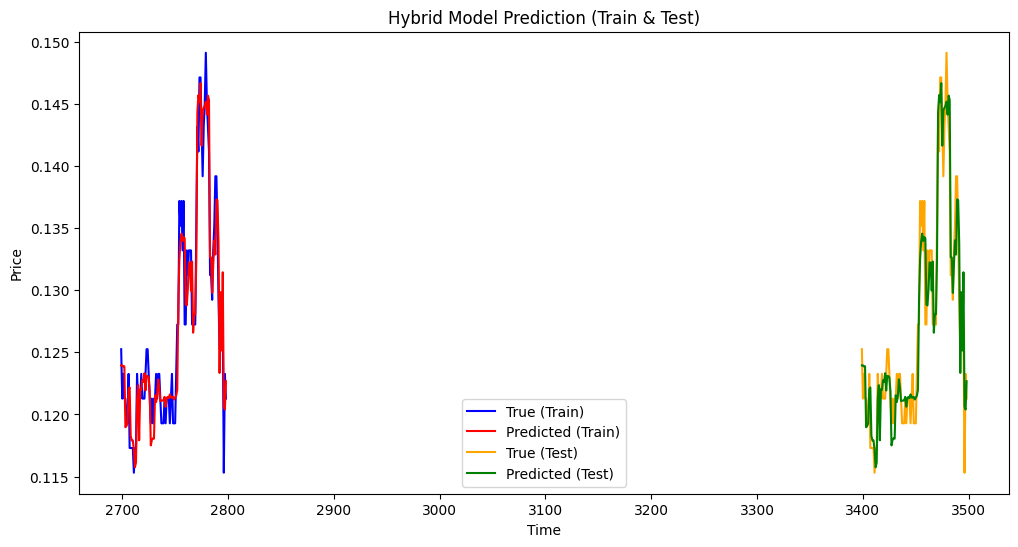

109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1 >expected=0.125249, predicted=0.123947
2 >expected=0.121272, predicted=0.123951
3 >expected=0.123260, predicted=0.123853
4 >expected=0.121272, predicted=0.123873
5 >expected=0.121272, predicted=0.118967
6 >expected=0.119284, predicted=0.119070
7 >expected=0.119284, predicted=0.119270
8 >expected=0.123260, predicted=0.122012
9 >expected=0.117296, predicted=0.122172
10 >expected=0.117296, predicted=0.118275
11 >expected=0.117296, predicted=0.117903
12 >expected=0.117296, predicted=0.117909
13 >expected=0.115308, predicted=0.117136
14 >expected=0.117296, predicted=0.115746
15 >expected=0.117296, predicted=0.116125
16 >expected=0.123260, predicted=0.121212
17 >expected=0.121272, predicted=0.122359
18 >expected=0.121272, predicted=0.117917
19 >expected=0.121272, predicted=0.122035
20 >expected=0.123260, predicted=0.121971
21 >expected=0.121272, predicted=0.122753
22 >expected=0.121272, predicted=0.122610
23 >expected=0.121272, predicted=0.123314
24

In [3]:

# Configure the training/testing split
def split_data(data, train_ratio=0.8):
    train_size = int(len(data) * train_ratio)
    train_data = data.iloc[:train_size, :]
    test_data = data.iloc[train_size:, :]

    if train_data.empty or test_data.empty:
        raise ValueError(
            f"Invalid split: Train data shape: {train_data.shape}, Test data shape: {test_data.shape}. "
            "Adjust train_ratio or check dataset size."
        )

    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")
    return train_data, test_data

def NormalizeMult(data):
    data = np.array(data, dtype='float64')
    num_features = data.shape[1]
    normalize = np.zeros((num_features, 2))
    normalized_data = np.zeros_like(data)

    for i in range(num_features):
        column_data = data[:, i]
        column_min, column_max = np.percentile(column_data, [0, 100])
        normalize[i] = [column_min, column_max]
        delta = column_max - column_min

        if delta != 0:
            normalized_data[:, i] = (column_data - column_min) / delta
        else:
            normalized_data[:, i] = 0.5

    return normalized_data, normalize

# Normalize and Prepare Data
def prepare_data(data, n_test, n_in, n_out):
    data, normalize = NormalizeMult(data)
    if len(data.shape) == 1:
        data = data.reshape(-1, 1)
    if data.shape[0] == 0 or data.shape[1] == 0:
        raise ValueError("Normalized data is empty. Check input data and normalization logic.")

    column_names = data_yuan.columns.tolist()

    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=column_names)

    if n_test is not None and n_in is not None and n_out is not None:
        total_samples = data.shape[0]
        train_size = total_samples - n_test
        train_data = data.iloc[:train_size]
        test_data = data.iloc[train_size:]
        return train_data, test_data, normalize

    return data, normalize

# Evaluate the model
def evaluate_model(data_train, data_test, data_yuan, model_name, INPUT_DIMS, TIME_STEPS):
    y_hat_train, y_train = PredictWithData(data_train, data_yuan, config.dimname, model_name, INPUT_DIMS, TIME_STEPS)
    y_hat_test, y_test = PredictWithData(data_test, data_yuan, config.dimname, model_name, INPUT_DIMS, TIME_STEPS)

    y_hat_train = np.array(y_hat_train, dtype='float64')
    y_train = np.array(y_train, dtype='float64')
    y_hat_test = np.array(y_hat_test, dtype='float64')
    y_test = np.array(y_test, dtype='float64')

    if y_hat_train.shape != y_train.shape:
        raise ValueError(f"Shape mismatch between predicted and actual values for training: {y_hat_train.shape} vs {y_train.shape}")
    if y_hat_test.shape != y_test.shape:
        raise ValueError(f"Shape mismatch between predicted and actual values for testing: {y_hat_test.shape} vs {y_test.shape}")

    evaluation_metric(y_train, y_hat_train, y_test, y_hat_test)

    time_train = pd.Series(data_train.index[-len(y_train):])
    time_test = pd.Series(data_test.index[-len(y_test):])

    plt.figure(figsize=(12, 6))
    plt.plot(time_train, y_train, label='True (Train)', color='blue')
    plt.plot(time_train, y_hat_train, label='Predicted (Train)', color='red')
    plt.plot(time_test, y_test, label='True (Test)', color='orange')
    plt.plot(time_test, y_hat_test, label='Predicted (Test)', color='green')

    plt.title('Hybrid Model Prediction (Train & Test)')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Prediction function
def PredictWithData(data, data_yuan, name, modelname, INPUT_DIMS=13, TIME_STEPS=20):
    yindex = data.columns.get_loc(name)

    data = np.array(data, dtype='float64')
    data, normalize = NormalizeMult(data)
    data_y = data[:, yindex].reshape(-1, 1)

    testX, _ = create_dataset(data, TIME_STEPS)
    _, testY = create_dataset(data_y, TIME_STEPS)

    if len(testY.shape) == 1:
        testY = testY.reshape(-1, 1)

    model = attention_model(INPUT_DIMS, TIME_STEPS)
    model.load_weights(modelname)
    y_hat = model.predict(testX)

    testY, y_hat = xgb_scheduler(data_yuan, y_hat)
    return y_hat, testY

# Define xgb_scheduler function
def xgb_scheduler(data, y_hat, n_test=100, n_in=6, n_out=1):
    close = data.pop('close')
    data.insert(5, 'close', close)
    train, test, normalize = prepare_data(data, n_test=n_test, n_in=n_in, n_out=n_out)

    testY, y_hat2 = walk_forward_validation(train, test)
    return testY, y_hat2


# Helper functions for xgb_scheduler
def walk_forward_validation(train, test):
    predictions = []
    train = train.values
    history = [x for x in train]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1], test.iloc[i, -1]
        yhat = xgboost_forecast(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i, :])
        print(i + 1, '>expected=%.6f, predicted=%.6f' % (testy, yhat))
    return test.iloc[:, -1], predictions

def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=20)
    model.fit(trainX, trainy)
    yhat = model.predict(np.asarray([testX]))
    return yhat[0]

def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back),:]
        dataX.append(a)
        dataY.append(dataset[i + look_back,:])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)

    return TrainX, Train_Y

# Normalize and Prepare Data
data, normalize = NormalizeMult(data)
print("Normalized data shape before converting to DataFrame:", data.shape)

# Dynamically assign column names based on the actual shape (6 columns as provided)
num_columns = data.shape[1]
column_names = ['open', 'high', 'low', 'close', 'vol', 'amount', '0'][:num_columns]
data = pd.DataFrame(data, columns=column_names)

# Debug final shapes
print("Final data shape after normalization:", data.shape)
print(f"Columns: {data.columns}")

# Rebuild Train/Test Data
train_data = data.iloc[:2799, :]
test_data = data.iloc[2799:, :]

# Debug Train/Test Shapes
print("Rebuilt Train data shape:", train_data.shape)
print("Rebuilt Test data shape:", test_data.shape)
print("Train Data Columns:", train_data.columns)
print("Test Data Columns:", test_data.columns)

# Define the config class
class Config:
    def __init__(self):
        self.dimname = 'close'

# Instantiate the config object
config = Config()

# Evaluate the Model
evaluate_model(
    train_data,
    test_data,
    data_yuan,
    './stock_model.keras',
    INPUT_DIMS=7,
    TIME_STEPS=20
)

# Predict with the Model
predictions, actuals = PredictWithData(
    data=data,
    data_yuan=data_yuan,
    name=config.dimname,
    modelname='./stock_model.keras',
    INPUT_DIMS=7,
    TIME_STEPS=20
)

# Debug Predictions
print("Predictions:", predictions[:10])
print("Actual values:", actuals[:10])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 100)                 │          20,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,901 (81.64 KB)

 Trainable params: 20,901 (81.64 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0330 - val_loss: 7.6097e-04
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - val_loss: 9.9432e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 9.6693e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 9.0658e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 8.5562e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0050 - val_loss: 8.0197e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 7.2953e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049 - val_loss: 6.5962e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 6.0891e-04
Epoch 12/5

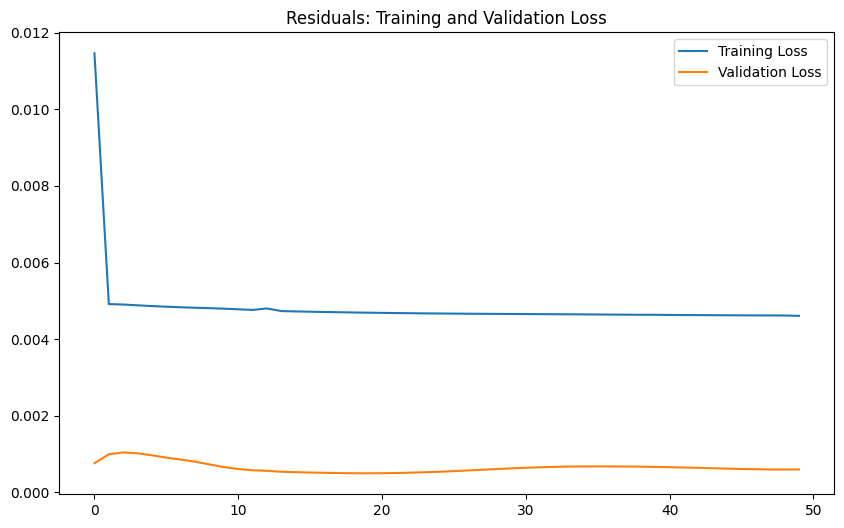

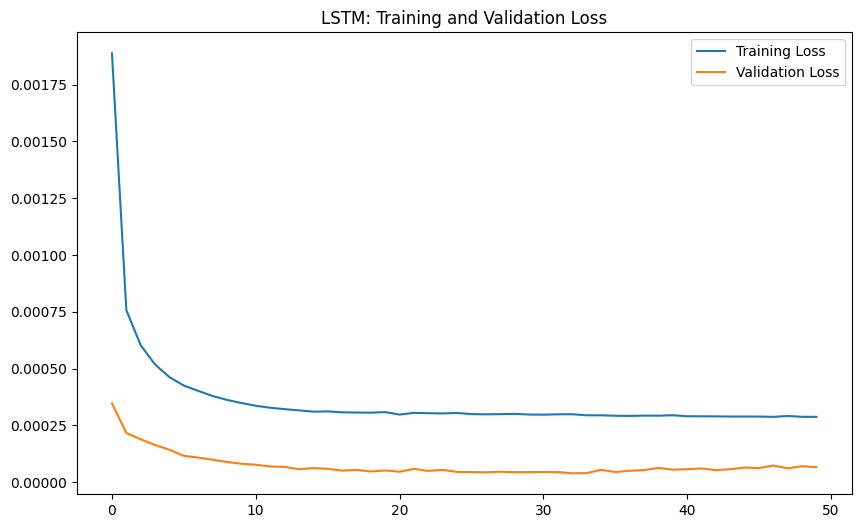

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


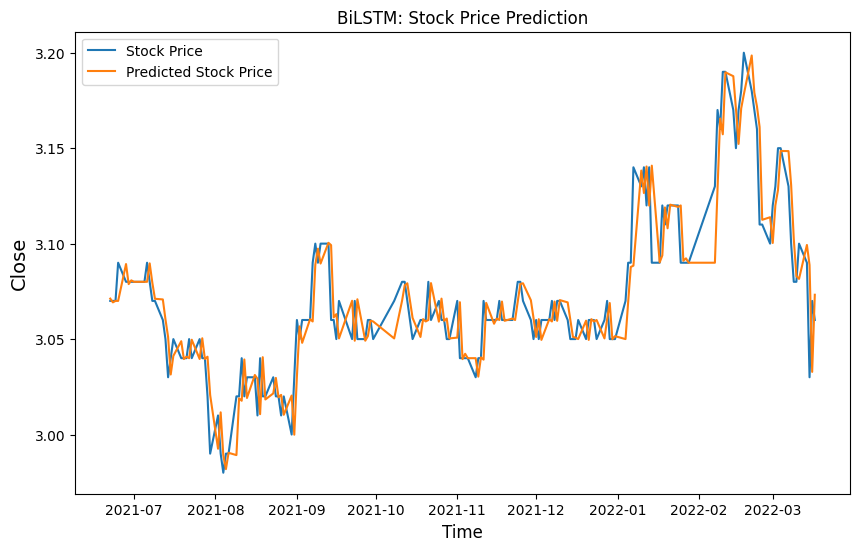

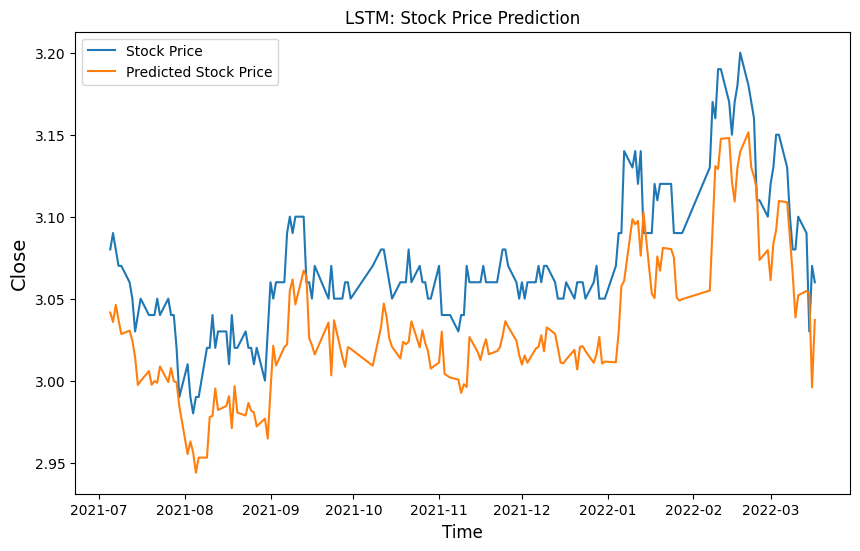


Training Metrics:
MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439
Accuracy: 99.61%

Testing Metrics:
MSE: 0.00027
RMSE: 0.01650
MAE: 0.01197
R2: 0.84439
Accuracy: 99.61%


In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.optimizers import Adam
from numpy.random import seed
from sklearn import metrics

def evaluation_metric(y_train, y_train_pred, y_test, y_test_pred):

    train_MSE = metrics.mean_squared_error(y_train, y_train_pred)
    train_RMSE = train_MSE**0.5
    train_MAE = metrics.mean_absolute_error(y_train, y_train_pred)
    train_R2 = metrics.r2_score(y_train, y_train_pred)
    train_avg_actual_value = np.mean(y_train)
    train_accuracy = (1 - train_MAE / train_avg_actual_value) * 100

    test_MSE = metrics.mean_squared_error(y_test, y_test_pred)
    test_RMSE = test_MSE**0.5
    test_MAE = metrics.mean_absolute_error(y_test, y_test_pred)
    test_R2 = metrics.r2_score(y_test, y_test_pred)
    test_avg_actual_value = np.mean(y_test)
    test_accuracy = (1 - test_MAE / test_avg_actual_value) * 100

    # Print training metrics
    print("\nTraining Metrics:")
    print('MSE: %.5f' % train_MSE)
    print('RMSE: %.5f' % train_RMSE)
    print('MAE: %.5f' % train_MAE)
    print('R2: %.5f' % train_R2)
    print('Accuracy: %.2f%%' % train_accuracy)

    print("\nTesting Metrics:")
    print('MSE: %.5f' % test_MSE)
    print('RMSE: %.5f' % test_RMSE)
    print('MAE: %.5f' % test_MAE)
    print('R2: %.5f' % test_R2)
    print('Accuracy: %.2f%%' % test_accuracy)

def data_split(sequence, n_timestamp):
    X = []
    y = []
    for i in range(len(sequence)):
        end_ix = i + n_timestamp

        if end_ix > len(sequence) - 1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def lstm(model_type, X_train, yX_train):
    if model_type == 1:
        # Single-layer LSTM
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
        model.add(Dense(units=1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(units=5))

    elif model_type == 2:
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=50, activation='relu'))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(LSTM(units=50, activation='relu', return_sequences=True, input_shape=(yX_train.shape[1], 5)))
        ymodel.add(LSTM(units=50, activation='relu'))
        ymodel.add(Dense(5))

    elif model_type == 3:
        model = Sequential()
        model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(X_train.shape[1], 1)))
        model.add(Dense(1))

        ymodel = Sequential()
        ymodel.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(yX_train.shape[1], 5)))
        ymodel.add(Dense(5))

    return model, ymodel

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.set_visible_devices([gpus[0]], "GPU")

seed(1)
tf.random.set_seed(1)

n_timestamp = 10
n_epochs = 50
model_type = 3

ydata = pd.read_csv('./601988.SH.csv')
ydata.index = pd.to_datetime(ydata['trade_date'], format='%Y%m%d')
ydata = ydata.loc[:, ['open', 'high', 'low', 'close', 'amount']]

data = pd.read_csv('./ARIMA_residuals1.csv')
data.index = pd.to_datetime(data['trade_date'])
data = data.drop('trade_date', axis=1)

Lt = pd.read_csv('./ARIMA.csv')
idx = 3500
training_set = data.iloc[1:idx, :]
test_set = data.iloc[idx:, :]
ytraining_set = ydata.iloc[1:idx, :]
ytest_set = ydata.iloc[idx:, :]

# Scale data
sc = MinMaxScaler(feature_range=(0, 1))
ysc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(test_set)
ytraining_set_scaled = ysc.fit_transform(ytraining_set)
ytesting_set_scaled = ysc.transform(ytest_set)

# Prepare training and test data
X_train, y_train = data_split(training_set_scaled, n_timestamp)
yX_train, yy_train = data_split(ytraining_set_scaled, n_timestamp)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
yX_train = yX_train.reshape(yX_train.shape[0], yX_train.shape[1], 5)

X_test, y_test = data_split(testing_set_scaled, n_timestamp)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
yX_test, yy_test = data_split(ytesting_set_scaled, n_timestamp)
yX_test = yX_test.reshape(yX_test.shape[0], yX_test.shape[1], 5)

# Build models
model, ymodel = lstm(model_type, X_train, yX_train)
print(model.summary())
adam_model = Adam(learning_rate=0.01)
adam_ymodel = Adam(learning_rate=0.01)

# Compile models
model.compile(optimizer=adam_model, loss='mse')
ymodel.compile(optimizer=adam_ymodel, loss='mse')
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=n_epochs,
                    validation_data=(X_test, y_test),
                    validation_freq=1)

yhistory = ymodel.fit(yX_train, yy_train,
                      batch_size=32,
                      epochs=n_epochs,
                      validation_data=(yX_test, yy_test),
                      validation_freq=1)

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Residuals: Training and Validation Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yhistory.history['loss'], label='Training Loss')
plt.plot(yhistory.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training and Validation Loss')
plt.legend()
plt.show()

# Predict and inverse transform
ypredicted_stock_price = ymodel.predict(yX_test)
ypredicted_stock_price = ysc.inverse_transform(ypredicted_stock_price)
ypredicted_stock_price_list = np.array(ypredicted_stock_price[:, 3]).flatten().tolist()
ypredicted_stock_price1 = pd.DataFrame({
    'trade_date': ydata.index[idx+10:],
    'close': ypredicted_stock_price_list
}).set_index(['trade_date'], drop=True)

yreal_stock_price = ysc.inverse_transform(yy_test)
yreal_stock_price_list = np.array(yreal_stock_price[:, 3]).flatten().tolist()
yreal_stock_price1 = pd.DataFrame({
    'trade_date': ydata.index[idx+10:],
    'close': yreal_stock_price_list
}).set_index(['trade_date'], drop=True)

predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
predicted_stock_price_list = np.array(predicted_stock_price[:, 0]).flatten().tolist()

predicted_stock_price1 = pd.DataFrame({
    'trade_date': data.index[idx+10:],
    'close': predicted_stock_price_list
}).set_index(['trade_date'], drop=True)

predicted_stock_price1.head()

real_stock_price = sc.inverse_transform(y_test)
finalpredicted_stock_price = pd.concat([Lt, predicted_stock_price1]).groupby('trade_date')['close'].sum().reset_index()
finalpredicted_stock_price.index = pd.to_datetime(finalpredicted_stock_price['trade_date'])
finalpredicted_stock_price = finalpredicted_stock_price.drop(['trade_date'], axis=1)

# Plot stock price predictions
plt.figure(figsize=(10, 6))
plt.plot(ydata.loc['2021-06-22':, 'close'], label='Stock Price')
plt.plot(finalpredicted_stock_price['close'], label='Predicted Stock Price')
plt.title('BiLSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=14)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(yreal_stock_price1['close'], label='Stock Price')
plt.plot(ypredicted_stock_price1['close'], label='Predicted Stock Price')
plt.title('LSTM: Stock Price Prediction')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Close', fontsize=14)
plt.legend()
plt.show()

# Evaluate model
yhat_test = ydata.loc['2021-06-22':, 'close']
evaluation_metric(yhat_test, finalpredicted_stock_price['close'], yhat_test, finalpredicted_stock_price['close'])
